In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/persian-tweets-emotional-dataset/fear.csv
/kaggle/input/persian-tweets-emotional-dataset/surprise.csv
/kaggle/input/persian-tweets-emotional-dataset/sad.csv
/kaggle/input/persian-tweets-emotional-dataset/anger.csv
/kaggle/input/persian-tweets-emotional-dataset/joy.csv
/kaggle/input/persian-tweets-emotional-dataset/disgust.csv
/kaggle/input/cleaned-data/cleaned_sad.csv
/kaggle/input/cleaned-data/cleaned_joy.csv
/kaggle/input/cleaned-data/cleaned_surprise.csv
/kaggle/input/cleaned-data/cleaned_anger.csv
/kaggle/input/cleaned-data/cleaned_fear.csv
/kaggle/input/cleaned-data/cleaned_disgust.csv


# Illustrating the classes distribution

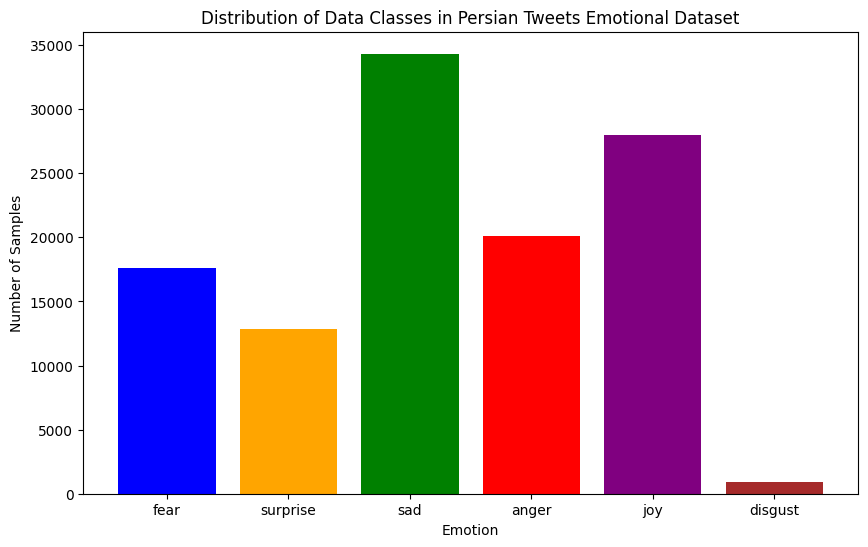

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_paths = {
    'fear': '/kaggle/input/persian-tweets-emotional-dataset/fear.csv',
    'surprise': '/kaggle/input/persian-tweets-emotional-dataset/surprise.csv',
    'sad': '/kaggle/input/persian-tweets-emotional-dataset/sad.csv',
    'anger': '/kaggle/input/persian-tweets-emotional-dataset/anger.csv',
    'joy': '/kaggle/input/persian-tweets-emotional-dataset/joy.csv',
    'disgust': '/kaggle/input/persian-tweets-emotional-dataset/disgust.csv'
}
class_counts = {}

for emotion, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    class_counts[emotion] = len(df)

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.title('Distribution of Data Classes in Persian Tweets Emotional Dataset')
plt.show()

In [ ]:
!pip install pandas transformers torch hazm cleantext parsivar



In [ ]:
import re, emoji
import gc
import pandas as pd
import hazm
from cleantext import clean
from transformers import AutoTokenizer, AutoModel, BertModel,BertTokenizer,AutoConfig
import torch
import os
import itertools
import torch.optim as optim

In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


# Preprocessing data

In [ ]:
normalizer = hazm.Normalizer()
stemmer = hazm.Stemmer()
tokenizer = hazm.WordTokenizer()

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)

    return cleantext

def removeDuplicateCharacters(input):

    regex = r'(.)\1+'

    return re.sub(regex, r'\1', input, flags=re.IGNORECASE)


def clean_urls(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')

    return url_pattern.sub(r'', text)


def replace_emojis(text):

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)


    def emoji_to_text(match):
        emoji_unicode = match.group(0)
        emoji_text = emoji.demojize(emoji_unicode,language = 'fa')
        return emoji_text

    text = emoji_pattern.sub(emoji_to_text, text)
    return text


def remove_stopwords(text):

    stopwords = set(hazm.stopwords_list())
    words = tokenizer.tokenize(text)
#     print("stopwords cleaned")
    return ' '.join([word for word in words if word not in stopwords])

def stemming(text):

    words = tokenizer.tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
#     print("stemming done")
    return ' '.join(stemmed_words)



def clean_text_pipeline(text):

    text = cleanhtml(text)
    text = clean_urls(text)
    text = replace_emojis(text)
    text = removeDuplicateCharacters(text)
    text = remove_stopwords(text)
#     text = stemming(text)
    text = normalizer.normalize(text)
    return text





In [ ]:
def clean_text(text):

    """Apply all cleaning steps sequentially."""
    steps = {
        'raw': text,
#         'cleaned_html': cleanhtml(text),
#            'cleaned_urls': clean_urls(text),
#         'normalized': normalizer.normalize(text),
        'removed_repetitive_characters': removeDuplicateCharacters(text),
#          'replaced_emojis': replace_emojis(text),
#         'removed_stopwords': remove_stopwords(text),
#         'stemmed': stemming(text)
    }
    return steps

In [ ]:
def load_and_process_data(file_path):

    df = pd.read_csv(file_path)
    df_cleaned = pd.DataFrame()
    df_cleaned['raw tweet'] = df['tweet']
    print("apply cleaning steps")
    df_cleaned['cleaned tweet'] = df['tweet'].apply(clean_text_pipeline)
    df_cleaned['emotion'] = df['emotion']
    return df_cleaned


file_paths = ['/kaggle/input/persian-tweets-emotional-dataset/sad.csv','/kaggle/input/persian-tweets-emotional-dataset/surprise.csv','/kaggle/input/persian-tweets-emotional-dataset/joy.csv','/kaggle/input/persian-tweets-emotional-dataset/fear.csv','/kaggle/input/persian-tweets-emotional-dataset/disgust.csv','/kaggle/input/persian-tweets-emotional-dataset/anger.csv']


for file_path in file_paths:

    file_name = os.path.basename(file_path)

    emotion = os.path.splitext(file_name)[0]

    df_output = load_and_process_data(file_path)
    df_output.to_csv(f'/kaggle/working/cleaned_{emotion}.csv', index=False)

# Tokenizing each tweet with parsebert tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")


In [ ]:
def tokenize_text(text):
    """Tokenize text and convert tokens to token IDs."""
    tokens = tokenizer.tokenize(text, padding='max_length', truncation=True, max_length=32, return_tensors="pt")
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    return token_ids

In [ ]:
def load_and_tokenize_data(file_path):
    """Load cleaned data from CSV and tokenize the tweets."""

    df = pd.read_csv(file_path)

    df['token_ids'] = df['cleaned tweet'].apply(tokenize_text)

    return df

In [ ]:

cleaned_file_paths = [
    '/kaggle/input/cleaned-data/cleaned_sad.csv',
    '/kaggle/input/cleaned-data/cleaned_surprise.csv',
    '/kaggle/input/cleaned-data/cleaned_joy.csv',
    '/kaggle/input/cleaned-data/cleaned_fear.csv',
    '/kaggle/input/cleaned-data/cleaned_disgust.csv',
    '/kaggle/input/cleaned-data/cleaned_anger.csv'
]

In [ ]:

for file_path in cleaned_file_paths:

    df_tokenized = load_and_tokenize_data(file_path)

    file_name = os.path.basename(file_path)

    emotion = os.path.splitext(file_name)[0]

    output_file_path = f'/kaggle/working/tokenized_{emotion}.csv'
    df_tokenized.to_csv(output_file_path, index=False)

    print(f"Tokenized {file_path} and saved to {output_file_path}")

In [ ]:
model_name = 'HooshvareLab/bert-fa-zwnj-base'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Modifying parsebert config and defining our custom model for word embedding extraction

In [ ]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
config.hidden_size = 120
modified_model = AutoModel.from_config(config)

print(modified_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 120, padding_idx=0)
    (position_embeddings): Embedding(512, 120)
    (token_type_embeddings): Embedding(2, 120)
    (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=120, out_features=120, bias=True)
            (key): Linear(in_features=120, out_features=120, bias=True)
            (value): Linear(in_features=120, out_features=120, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=120, out_features=120, bias=True)
            (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modified_model.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 120, padding_idx=0)
    (position_embeddings): Embedding(512, 120)
    (token_type_embeddings): Embedding(2, 120)
    (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=120, out_features=120, bias=True)
            (key): Linear(in_features=120, out_features=120, bias=True)
            (value): Linear(in_features=120, out_features=120, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=120, out_features=120, bias=True)
            (LayerNorm): LayerNorm((120,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
import pandas as pd

anger_df = pd.read_csv('/kaggle/input/cleaned-data/cleaned_anger.csv')
surprise_df = pd.read_csv('/kaggle/input/cleaned-data/cleaned_surprise.csv')
joy_df = pd.read_csv('/kaggle/input/cleaned-data/cleaned_joy.csv')
sad_df = pd.read_csv('/kaggle/input/cleaned-data/cleaned_sad.csv')
disgust_df = pd.read_csv('/kaggle/input/cleaned-data/cleaned_disgust.csv')
fear_df = pd.read_csv('/kaggle/input/cleaned-data/cleaned_fear.csv')

df_list = [anger_df, surprise_df, joy_df, sad_df, disgust_df, fear_df]

df = pd.concat([anger_df, surprise_df, joy_df, sad_df, disgust_df, fear_df], ignore_index=True)
texts = df['cleaned tweet'].tolist()

In [ ]:
def tokenize_text(text):
    """Tokenize text and convert tokens to token IDs."""
    encoded_input = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=32,
        return_tensors='pt'
    )
    input_ids = encoded_input['input_ids']
    attention_mask = encoded_input['attention_mask']

    return {
        'input_ids': input_ids.squeeze().tolist(),
        'attention_mask': attention_mask.squeeze().tolist()
    }



In [ ]:
def load_and_tokenize_data(df):
    """Tokenize the 'cleaned tweet' column and convert to token IDs."""
    tokenized_data = df['cleaned tweet'].apply(tokenize_text).tolist()

    input_ids = [item['input_ids'] for item in tokenized_data]
    attention_mask = [item['attention_mask'] for item in tokenized_data]

    return torch.tensor(input_ids), torch.tensor(attention_mask)


In [ ]:
input_ids_all = []
attention_mask_all = []

for df in df_list:
    print("tokenizing started")
    input_ids, attention_mask = load_and_tokenize_data(df)
    input_ids_all.append(input_ids)
    attention_mask_all.append(attention_mask)

input_ids_all = torch.cat(input_ids_all, dim=0)
attention_mask_all = torch.cat(attention_mask_all, dim=0)

In [ ]:
print(input_ids_all.shape)
print(attention_mask_all.shape)

In [ ]:

def get_embeddings(input_ids, attention_mask, model):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state
    return embeddings




In [ ]:
def process_in_batches(input_ids, attention_mask, batch_size, model):
    num_batches = len(input_ids) // batch_size + (1 if len(input_ids) % batch_size != 0 else 0)
    all_word_embeddings = []

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(input_ids))

        input_ids_batch = input_ids[start_idx:end_idx]
        attention_mask_batch = attention_mask[start_idx:end_idx]

        embeddings = get_embeddings(input_ids_batch, attention_mask_batch, model).to(device)

        all_word_embeddings.append(embeddings)

        del input_ids_batch, attention_mask_batch, embeddings
        gc.collect()
        torch.cuda.empty_cache()

    return torch.cat(all_word_embeddings, dim=0)

In [ ]:
batch_size = 32
emotion_embeddings_dict = {}

for emotion in ['anger', 'surprise', 'joy', 'sad', 'disgust', 'fear']:
    emotion_embeddings_dict[emotion] = []

for df, emotion in zip(df_list, ['anger', 'surprise', 'joy', 'sad', 'disgust', 'fear']):
    input_ids, attention_mask = load_and_tokenize_data(df)
    print(f"{emotion} tokenized")
    word_embeddings = process_in_batches(input_ids, attention_mask, batch_size, modified_model)
    print(f"{emotion} embedded")

    if word_embeddings.is_cuda:
        word_embeddings = word_embeddings.cpu()

    word_embeddings_np = word_embeddings.detach().numpy()
    emotion_embeddings_dict[emotion].append(word_embeddings_np)


anger tokenized
anger embedded
surprise tokenized
surprise embedded
joy tokenized
joy embedded
sad tokenized
sad embedded
disgust tokenized
disgust embedded
fear tokenized
fear embedded


In [ ]:
print(emotion_embeddings_dict["anger"])

[array([[[-0.552589  ,  0.38869655,  1.7415609 , ..., -2.489089  ,
         -0.16062814,  0.12908986],
        [-0.3824045 ,  0.7108481 ,  1.0293214 , ..., -0.26425016,
         -0.85783654, -0.6847405 ],
        [ 0.33940887, -0.8836298 , -0.9784379 , ...,  0.22692755,
          0.18162638,  1.090348  ],
        ...,
        [-0.31551725, -0.01484386,  1.314857  , ...,  0.5896346 ,
         -1.0474943 , -0.5479178 ],
        [ 0.04054109, -0.23949549,  0.2143136 , ..., -0.8980165 ,
         -0.21446034, -0.7894819 ],
        [ 0.21094503, -1.1167469 ,  1.6605812 , ..., -0.04174727,
         -1.9369301 ,  0.2323866 ]],

       [[-0.7237773 ,  0.4011339 ,  2.0411534 , ..., -2.1782024 ,
         -0.00660157, -0.1391044 ],
        [ 1.2729304 , -1.8515061 , -0.30044815, ..., -0.2991822 ,
         -0.897607  , -0.30356717],
        [ 0.7420956 ,  0.1601639 ,  0.22783719, ...,  1.6858271 ,
         -0.5706523 ,  1.7818509 ],
        ...,
        [ 0.6274265 ,  0.5013611 ,  2.330545  , ..., 

In [ ]:
!pip install scikit-learn
!pip install keras

now we have word embedding for each token in each sentence, in other words, each tweet is converted into a (32,120) tensor where 32 refers to the number of tokens and the 120 refers to the size of embedding.
# Now we need to define three models namely lstm_cnn, cnn, and lstm. The word embeddings will be passed through these three models.

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, MaxPooling1D,BatchNormalization,Input,Reshape

import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

2024-05-29 15:07:24.216886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 15:07:24.216946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 15:07:24.218863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
pip install --upgrade tensorflow


  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0
    Uninstalling tensorflow-2.12.0:
      Successfully unins

In [ ]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikeras

In [ ]:
# Define model
lstm_cnn = Sequential()

# Add Convolutional layer
lstm_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 120)))
lstm_cnn.add(MaxPooling1D(pool_size=2))

# Add LSTM layer
lstm_cnn.add(LSTM(units=100))

# Add Dense layer
lstm_cnn.add(Dense(units=6, activation='softmax'))



In [ ]:
lstm_cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 30, 64)         │        23,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,710 (350.43 KB)

 Trainable params: 89,710 (350.43 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

cnn = Sequential()

cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 120)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(units=6, activation='softmax'))


In [ ]:
cnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 30, 64)         │        23,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         5,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,612 (338.33 KB)

 Trainable params: 28,870 (112.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 57,742 (225.56 KB)

In [ ]:
lstm_output_size = 100
lstm = Sequential()
lstm.add(LSTM(lstm_output_size))
lstm.add(BatchNormalization())
lstm.add(Dropout(0.1))
lstm.add(Dense(6, activation="softmax"))

# Now we train these three models with our word embeddings

In [ ]:
emotion_tensors_dict = {}
for emotion, embeddings_list in emotion_embeddings_dict.items():
    emotion_tensors_dict[emotion] = np.stack(embeddings_list)


for emotion, tensor in emotion_tensors_dict.items():
    emotion_tensors_dict[emotion] = tensor.squeeze(axis=0)

emotion_to_digit = {'anger': 0, 'surprise': 1, 'joy': 2, 'sad': 3, 'disgust': 4, 'fear': 5}

emotion_embeddings = []
emotion_labels = []


for emotion, embeddings in emotion_tensors_dict.items():
    print(embeddings.shape)
    labels = np.full((len(embeddings),), fill_value=emotion_to_digit[emotion])  # Convert emotion labels to digits
    emotion_embeddings.append(embeddings)
    emotion_labels.append(labels)


X = np.concatenate(emotion_embeddings, axis=0)
y = np.concatenate(emotion_labels, axis=0)

print("X shape:", X.shape)
print("y shape:", y.shape)

(20069, 32, 120)
(12859, 32, 120)
(28024, 32, 120)
(34328, 32, 120)
(925, 32, 120)
(17624, 32, 120)
X shape: (113829, 32, 120)
y shape: (113829,)


In [ ]:

np.save('/kaggle/working/emotion_embeddings.npy', X)
np.save('/kaggle/working/emotion_labels.npy', y)

In [ ]:

X = np.load('/kaggle/working/emotion_embeddings.npy')
y = np.load('/kaggle/working/emotion_labels.npy')

Gready search

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle = True)

In [1]:
!pip install scikeras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD

def create_model(batch_size=32, lstm_units=100, optimizer='adam', learning_rate=0.001):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 120)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=lstm_units))
    model.add(Dense(units=6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, verbose=0)

param_grid = {
    'batch_size': [8, 64],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.001, 0.01]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


Optimizer: adam, Learning Rate: 0.001, Batch Size: 8
Epoch 1/5
7968/7968 - 19s 5ms/step - loss: 0.4818 
Epoch 2/5
7968/7968 - 20s 33ms/step - loss: 0.4478 
Epoch 3/5
7958/7968 - 0s 4ms/step - loss: 0.4320
7968/7968 - 22s 21ms/step - loss: 0.4320 
Epoch 4/5
7968/7968 - 25s 7ms/step - loss: 0.3820 
Epoch 5/5
7966/7968 - 0s 4ms/step - loss: 0.3473
7968/7968 - 25s 27ms/step - loss: 0.3473 
1068/1068 - 3s 2ms/step - loss: 0.5598

Optimizer: adam, Learning Rate: 0.01, Batch Size: 8
Epoch 1/5
7968/7968 - 21s 2ms/step - loss: 0.5194 
Epoch 2/5
7968/7968 - 35s 33ms/step - loss: 0.4863 
Epoch 3/5
7958/7968 - 0s 4ms/step -  loss: 0.4701
7968/7968 - 47s 3ms/step - loss: 0.4700 
Epoch 4/5
7968/7968 - 34s 4ms/step - loss: 0.4387 
Epoch 5/5
7966/7968 - 0s 21ms/step - loss: 0.4201
7968/7968 - 26s 4ms/step - loss: 0.4201 
1068/1068 - 3s 2ms/step - loss: 0.5851

Optimizer: sgd, Learning Rate: 0.001, Batch Size: 8
Epoch 1/5
7968/7968 - 38s 5ms/step - loss: 0.5456 
Epoch 2/5
7968/7968 - 32s 4ms/step - lo

In [ ]:

learning_rates = [0.001]
optimizers = ['adam']
batch_sizes = [8]



In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam, SGD

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle = True)
for lr in learning_rates:
    for opt in optimizers:
        for batch_size in batch_sizes:

            if opt == 'adam':
                optimizer = Adam(learning_rate=lr)
            elif opt == 'sgd':
                optimizer = SGD(learning_rate=lr)

            lstm_cnn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

            callbacks_list = [
                ModelCheckpoint(filepath=f'logs/cnn-lstm/model-{opt}-{lr}-{batch_size}.keras',
                                save_best_only=True, monitor='val_loss', mode='min'),
                EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.0001, mode='min', verbose=1)
            ]


            history = lstm_cnn.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val),
                     verbose=1, shuffle = True, callbacks=callbacks_list)

            loss, accuracy = lstm_cnn.evaluate(X_test, y_test)
            print(f"\nOptimizer: {opt}, Learning Rate: {lr}, Batch Size: {batch_size}")
            print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

Epoch 1/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.8299 - loss: 0.4818 - val_accuracy: 0.8198 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 2/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.8411 - loss: 0.4478 - val_accuracy: 0.8145 - val_loss: 0.5273 - learning_rate: 0.0010
Epoch 3/10
7958/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8456 - loss: 0.4320
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8455 - loss: 0.4320 - val_accuracy: 0.8153 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 4/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.8641 - loss: 0.3820 - val_accuracy: 0.8165 - val_loss: 0.5329 - learning_rate: 4.0000e-04
Epoch 5/10
7966/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8785 - loss: 0.3473
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.

1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


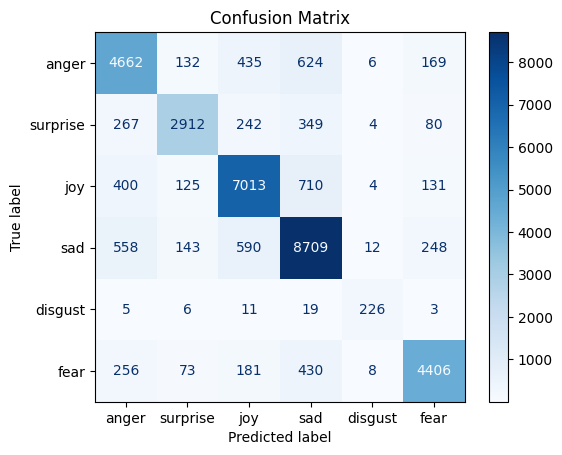

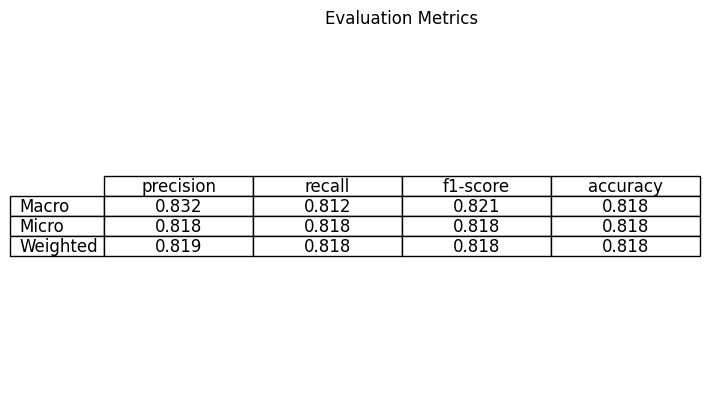

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

y_pred = lstm_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

def plot_confusion_matrix(y_test, y_pred_classes):
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_to_digit.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_classes)

def calculate_metrics(y_test, y_pred_classes):
    metrics = {}
    for avg in ['macro', 'micro', 'weighted']:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=avg)
        accuracy = np.mean(y_pred_classes == y_test)
        metrics[avg] = {
            'precision': round(precision,3),
            'recall': round(recall,3),
            'f1-score': round(f1,3),
            'accuracy': round(accuracy,3)
        }
    return metrics

metrics = calculate_metrics(y_test, y_pred_classes)

def plot_metrics_table(metrics):
    df = pd.DataFrame(metrics).T
    df.index = df.index.str.capitalize()

    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    plt.title('Evaluation Metrics')
    plt.show()



plot_metrics_table(metrics)


In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam, SGD

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle = True)
for lr in learning_rates:
    for opt in optimizers:
        for batch_size in batch_sizes:

            if opt == 'adam':
                optimizer = Adam(learning_rate=lr)
            elif opt == 'sgd':
                optimizer = SGD(learning_rate=lr)

            lstm.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

            callbacks_list = [
             ModelCheckpoint(filepath=f'logs/cnn-lstm/model-{opt}-{lr}-{batch_size}.keras',
                                save_best_only=True, monitor='val_loss', mode='min'),
                EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.0001, mode='min', verbose=1)
            ]


            history2 = lstm.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val),
                     verbose=1, shuffle = True, callbacks=callbacks_list)

            loss, accuracy = lstm.evaluate(X_test, y_test)
            print(f"\nOptimizer: {opt}, Learning Rate: {lr}, Batch Size: {batch_size}")
            print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

Epoch 1/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.8158 - loss: 0.5713 - val_accuracy: 0.8256 - val_loss: 0.5200 - learning_rate: 0.0010
Epoch 2/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8286 - loss: 0.5276 - val_accuracy: 0.8327 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 3/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8394 - loss: 0.4998 - val_accuracy: 0.8225 - val_loss: 0.5343 - learning_rate: 0.0010
Epoch 4/10
7966/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8472 - loss: 0.4759
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8472 - loss: 0.4759 - val_accuracy: 0.8264 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 5/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.8704 - loss: 0.4105 - val_accuracy: 0.8329 - val_loss: 0.5437 - learning_rate: 4.0000e-04
Epoch 6/10
7962/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.

1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


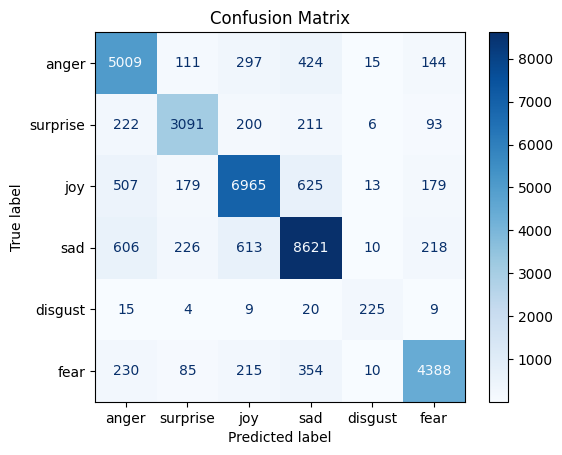

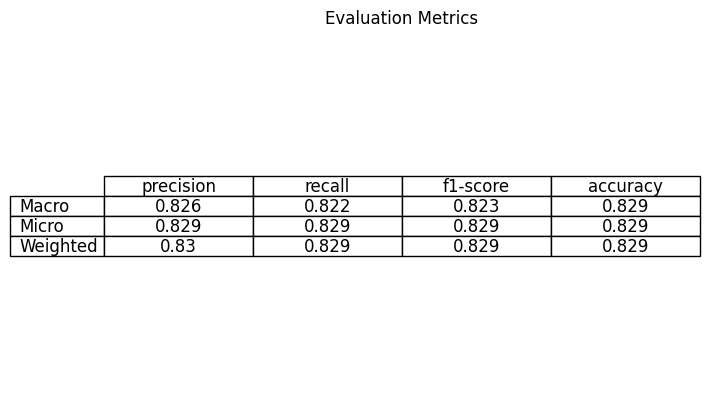

In [ ]:
y_pred = lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

def plot_confusion_matrix(y_test, y_pred_classes):
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_to_digit.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_classes)

def calculate_metrics(y_test, y_pred_classes):
    metrics = {}
    for avg in ['macro', 'micro', 'weighted']:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=avg)
        accuracy = np.mean(y_pred_classes == y_test)
        metrics[avg] = {
            'precision': round(precision,3),
            'recall': round(recall,3),
            'f1-score': round(f1,3),
            'accuracy': round(accuracy,3)
        }
    return metrics

metrics = calculate_metrics(y_test, y_pred_classes)

def plot_metrics_table(metrics):
    df = pd.DataFrame(metrics).T
    df.index = df.index.str.capitalize()

    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    plt.title('Evaluation Metrics')
    plt.show()



plot_metrics_table(metrics)


In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam, SGD


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle = True)
for lr in learning_rates:
    for opt in optimizers:
        for batch_size in batch_sizes:

            if opt == 'adam':
                optimizer = Adam(learning_rate=lr)
            elif opt == 'sgd':
                optimizer = SGD(learning_rate=lr)

            cnn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

            callbacks_list = [
                ModelCheckpoint(filepath=f'logs/cnn-lstm/model-{opt}-{lr}-{batch_size}.keras',
                                save_best_only=True, monitor='val_loss', mode='min'),
                EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=0.0001, mode='min', verbose=1)
            ]


            history3 = cnn.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val),
                     verbose=1, shuffle = True, callbacks=callbacks_list)

            loss, accuracy = cnn.evaluate(X_test, y_test)
            print(f"\nOptimizer: {opt}, Learning Rate: {lr}, Batch Size: {batch_size}")
            print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

Epoch 1/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7156 - loss: 0.7994 - val_accuracy: 0.7161 - val_loss: 0.7990 - learning_rate: 0.0010
Epoch 2/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7199 - loss: 0.7691 - val_accuracy: 0.7208 - val_loss: 0.8041 - learning_rate: 0.0010
Epoch 3/10
7961/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7241 - loss: 0.7571
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7241 - loss: 0.7571 - val_accuracy: 0.7210 - val_loss: 0.8143 - learning_rate: 0.0010
Epoch 4/10
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7353 - loss: 0.7210 - val_accuracy: 0.7225 - val_loss: 0.8038 - learning_rate: 4.0000e-04
Epoch 5/10
7958/7968 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7386 - loss: 0.7010
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00016000000759959222.
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.

1068/1068 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


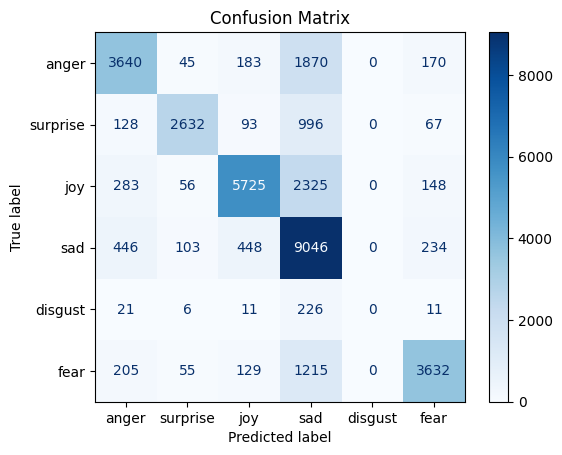

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


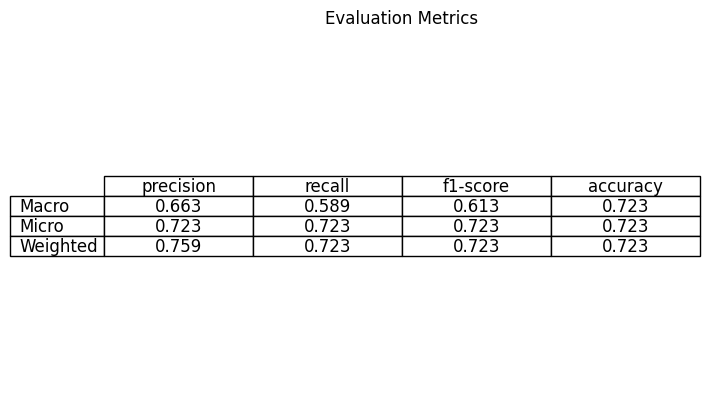

In [ ]:
y_pred = cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

def plot_confusion_matrix(y_test, y_pred_classes):
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotion_to_digit.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_classes)

def calculate_metrics(y_test, y_pred_classes):
    metrics = {}
    for avg in ['macro', 'micro', 'weighted']:
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=avg)
        accuracy = np.mean(y_pred_classes == y_test)
        metrics[avg] = {
            'precision': round(precision,3),
            'recall': round(recall,3),
            'f1-score': round(f1,3),
            'accuracy': round(accuracy,3)
        }
    return metrics

metrics = calculate_metrics(y_test, y_pred_classes)

def plot_metrics_table(metrics):
    df = pd.DataFrame(metrics).T
    df.index = df.index.str.capitalize()

    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    plt.title('Evaluation Metrics')
    plt.show()



plot_metrics_table(metrics)